In [1]:
import re
import cv2 
import numpy as np
import pytesseract
from pytesseract import Output
from matplotlib import pyplot as plt

In [2]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

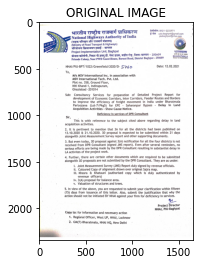

In [3]:
# Plot original image

image = cv2.imread('out.jpg')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.imshow(rgb_img)
plt.title('ORIGINAL IMAGE')
plt.show()

In [4]:
# Preprocess image 

gray = get_grayscale(image)
thresh = thresholding(gray)
opening = opening(gray)
canny = canny(gray)
images = {'gray': gray, 
          'thresh': thresh, 
          'opening': opening, 
          'canny': canny}

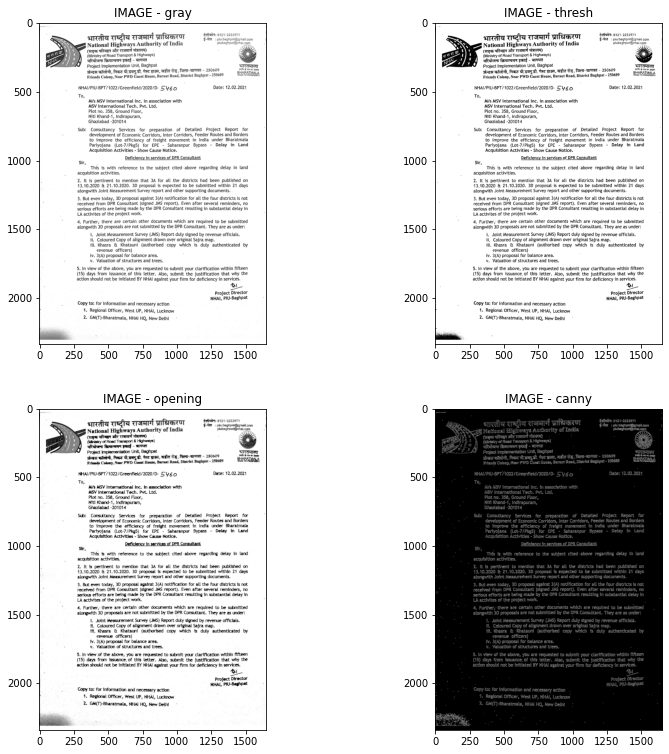

In [5]:
# Plot images after preprocessing

fig = plt.figure(figsize=(13,13))
ax = []

rows = 2
columns = 2
keys = list(images.keys())
for i in range(rows*columns):
    ax.append( fig.add_subplot(rows, columns, i+1) )
    ax[-1].set_title('IMAGE - ' + keys[i]) 
    plt.imshow(images[keys[i]], cmap='gray')

In [6]:

# Get OCR output using Pytesseract

custom_config = r'-l hin+eng --oem 3 --psm 6'
print('-----------------------------------------')
print('TESSERACT OUTPUT --> ORIGINAL IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> THRESHOLDED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> OPENED IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))
print('\n-----------------------------------------')
print('TESSERACT OUTPUT --> CANNY EDGE IMAGE')
print('-----------------------------------------')
print(pytesseract.image_to_string(image, config=custom_config))

-----------------------------------------
TESSERACT OUTPUT --> ORIGINAL IMAGE
-----------------------------------------
४ टेलीफोन: 0121-2222971 ‘
S = भारतीय राष्ट्रीय राजमार्ग प्राधिकरण ई-मेल : piu.baghpat@gmail.com f£
ean National Highways Authority of India piubaghpat@nhai.com
ae (सड़क परिवहन और राजमार्ग मंत्रालय)... . डै&
FAL a 1। ! (Ministry of Road Transport & Highways) ;
Nl (9 ve i | परियोजना क्रियान्वयन इकाई - बागपत : ,
u Project Implementation Unit, Baghpat है भारतमाला
फ्रेन्डस कॉलोनी, निकट पी.डब्लू:डी. गेस्ट हाउस, बडौत रोड़, जिला-बागपत - 250609 BHARATMALA
Friends Colony, Near PWD Guest House, Baraut Road, District Baghpat - 250609 ROAD TO PROSPERITY
; NHAI/PIU-BPT/1022/Greenfield/2020/D- 5५060 Date: 12.02.2021
To, ४
M/s MSV International Inc. in association with
MSV International Tech. Pvt. Ltd.
Plot no. 358, Ground Floor,
; ; Niti Khand-1, Indirapuram,
Ghaziabad -201014
Sub: Consultancy Services for preparation of Detailed Project Report for है
* development of Economic Corri

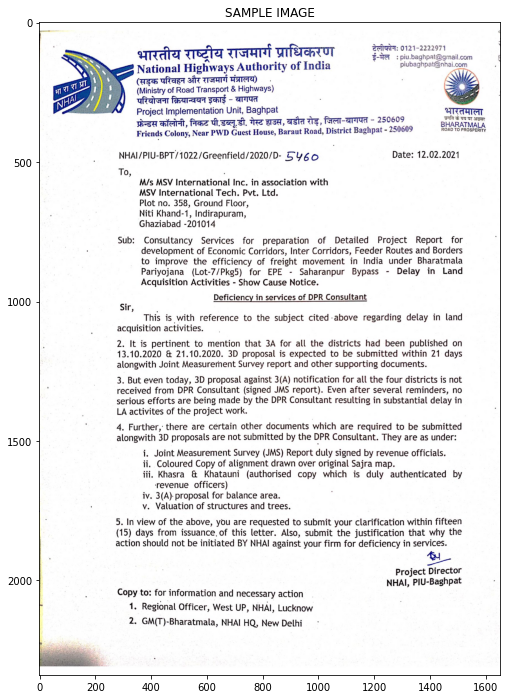

In [7]:
# Plot original image

image = cv2.imread('out.jpg')
b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])

plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE IMAGE')
plt.show()

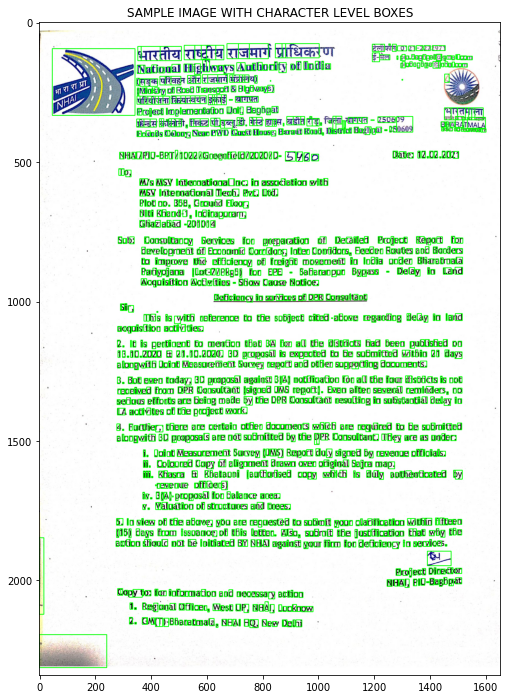

In [8]:

# Plot character boxes on image using pytesseract.image_to_boxes() function

image = cv2.imread('out.jpg')
h, w, c = image.shape
boxes = pytesseract.image_to_boxes(image) 
for b in boxes.splitlines():
    b = b.split(' ')
    image = cv2.rectangle(image, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])

plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE IMAGE WITH CHARACTER LEVEL BOXES')
plt.show()
plt.imsave("ocr_result_with_character_level_boxes.png", rgb_img)

DATA KEYS: 
 dict_keys(['level', 'page_num', 'block_num', 'par_num', 'line_num', 'word_num', 'left', 'top', 'width', 'height', 'conf', 'text'])


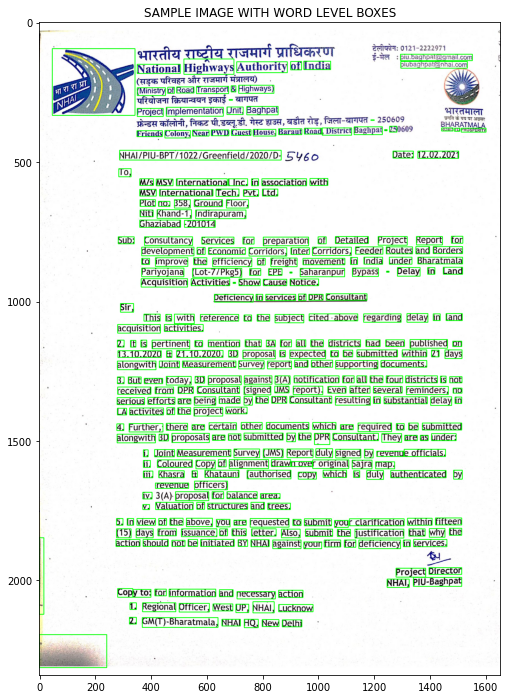

In [9]:

# Plot word boxes on image using pytesseract.image_to_data() function

image = cv2.imread('out.jpg')
d = pytesseract.image_to_data(image, output_type=Output.DICT)
print('DATA KEYS: \n', d.keys())

n_boxes = len(d['text'])
for i in range(n_boxes):
    # condition to only pick boxes with a confidence > 60%
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE IMAGE WITH WORD LEVEL BOXES')
plt.show()
plt.imsave("ocr_result_with_word_level_boxes.png", rgb_img)

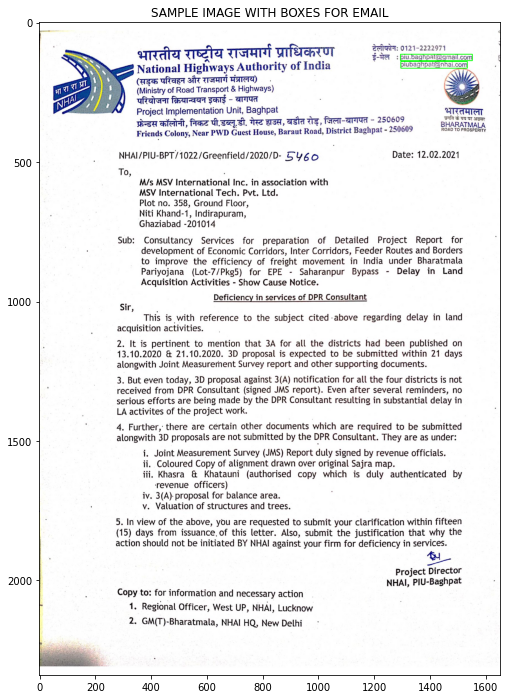

In [10]:
# Plot boxes around text that matches a certain regex template
# In this example we will extract the date from the sample invoice

image = cv2.imread('out.jpg')
email_pattern = '^\w+([.-]?\w+)*@\w+([.-]?\w+)*(\.\w{2,3})+$'

n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        if re.match(email_pattern, d['text'][i]):
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE IMAGE WITH BOXES FOR EMAIL')
plt.show()
plt.imsave("ocr_result_with_boxes_for dates.png", rgb_img)

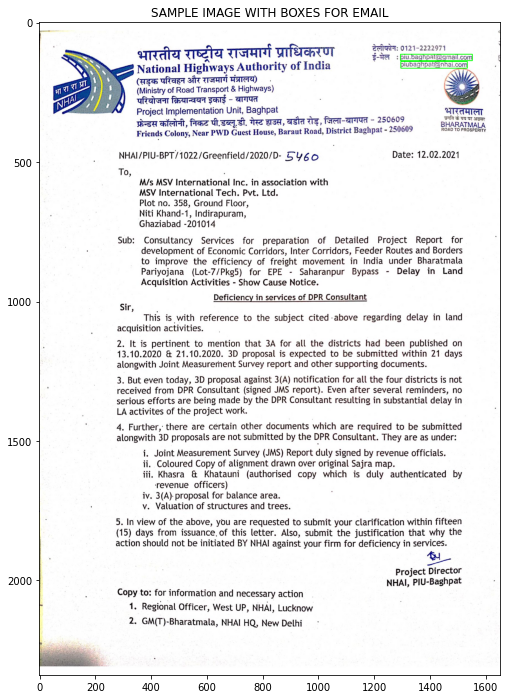

In [28]:
# Plot boxes around text that matches a certain regex template
# In this example we will extract the date from the sample invoice

image = cv2.imread('out.jpg')

d = pytesseract.image_to_data(image, output_type=Output.DICT)
keys = list(d.keys())

address_pattern = '[^@]+@[^@]+\.[^@]+'

n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        if re.match(address_pattern, d['text'][i]):
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE IMAGE WITH BOXES FOR EMAIL')
plt.show()
plt.imsave("ocr_result_with_boxes_for dates.png", rgb_img)

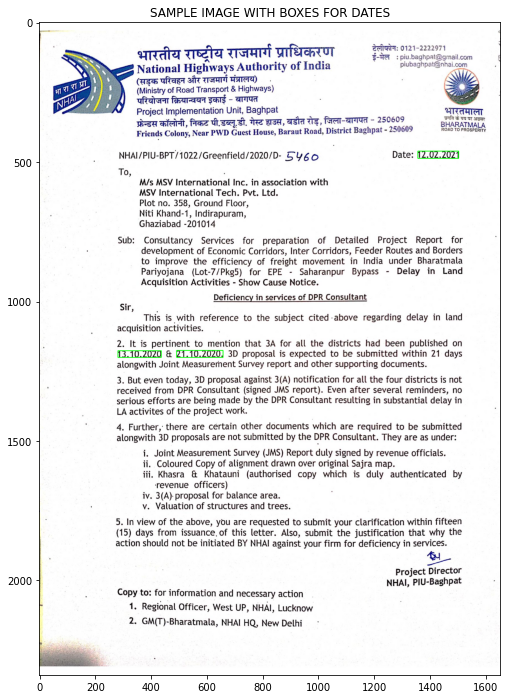

In [12]:
# Plot boxes around text that matches a certain regex template
# In this example we will extract the date from the sample invoice

image = cv2.imread('out.jpg')
date_pattern = '^(0[1-9]|[12][0-9]|3[01]).(0[1-9]|1[012]).(19|20)\d\d'

n_boxes = len(d['text'])
for i in range(n_boxes):
    if int(d['conf'][i]) > 60:
        if re.match(date_pattern, d['text'][i]):
            (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
            image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

b,g,r = cv2.split(image)
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(16,12))
plt.imshow(rgb_img)
plt.title('SAMPLE IMAGE WITH BOXES FOR DATES')
plt.show()
plt.imsave("ocr_result_with_boxes_for dates.png", rgb_img)

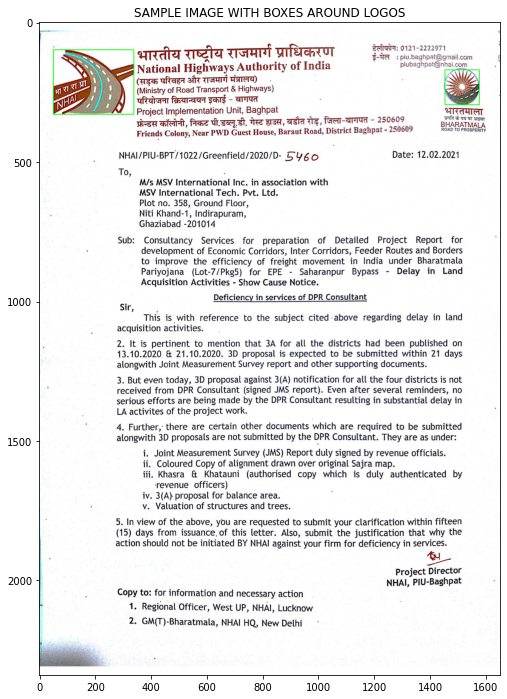

In [32]:
import cv2
image = cv2.imread("out.jpg")
img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU,img)
cv2.bitwise_not(img,img)
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, rect_kernel)
contours, hier = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

if len(contours) != 0:
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        if(h>100):
            cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)

plt.figure(figsize=(16,12))
plt.imshow(image)
plt.title('SAMPLE IMAGE WITH BOXES AROUND LOGOS')
plt.show()

In [23]:
import re

custom_config = r'-l hin+eng --oem 3 --psm 6'
Img_text = pytesseract.image_to_string(image, config=custom_config)

# dateRegex = re.compile(r'^(0[1-9]|[12][0-9]|3[01]).(0[1-9]|1[012]).(19|20)\d\d')
# print (dateRegex)
# mo = dateRegex.search('My number is 12.02.2021') 
# print(mo.group()) 

dateRegex = re.compile(r'\s(0[1-9]|[12][0-9]|3[01])\.(0[1-9]|1[012])\.(19|20)\d\d') 
for match in dateRegex.findall(Img_text):
    print("Date : ", match[0]+"."+match[1]+"."+match[2])
printt("The number of items that mathces with the Date Regex are : ", )
    
PinCodeRegex = re.compile(r'\b[1-9]{1}[0-9]{2}[0-9]{3}\b') 
for match in PinCodeRegex.findall(Img_text):
    print("Pin : ", match) 
    
PhoneRegex = re.compile(r'\d{4}([-]*)\d{7}') 
for match in PhoneRegex.findall(Img_text):
    print("Phone : ", match)

Date :  12.02.20
Date :  13.10.20
Date :  21.10.20
Pin :  250609
Pin :  250609
Pin :  201014
Phone :  -
